# Convolutional Variational Autoencoder

이번 실습에서는 Convolutional Variational Autoencoder를 구현하고, MNIST data를 이용하여 학습해보도록 하겠습니다.  
Input을 latent vector에 바로 매핑하는 Autoencoder와 달리, Variational Autoencoder는 입력 데이터를 확률 분포의 매개변수에 매핑합니다.  
  
첫 번째 실습에서는 encoder, decoder layer에 linear layer를 사용했지만, 본 실습에서는 이미지 처리에 더 적합한 convolution layer를 사용하여 encoder, decoder를 구현하도록 하겠습니다.

- 이 실습자료는 [텐서플로우 Convolutional Variational Autoencoder 실습자료](https://www.tensorflow.org/tutorials/generative/cvae)를 기반으로 작성되었습니다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

DEVICE = torch.device("cuda")

## Load the MNIST dataset

MNIST 데이터셋은 28x28 크기의 그레이 스케일 이미지로 구성된 데이터셋입니다.
Fashion MNIST와 달리, 0~9 까지의 숫자 이미지들에 대한 데이터셋입니다.
총 10개의 클래스를 합쳐 60,000개의 train set, 10,000개의 test set으로 구성되어있습니다.  
본 실습은 MNIST 이미지를 latent 압축/복원하는 convolutional variational autoencoder를 구현해보는 실습입니다.  

실습에 앞서 필요한 데이터를 로드하도록 하겠습니다.
아래 코드는 MNIST 데이터를 로드하는 코드입니다.

In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

dataset_path = './datasets'
batch_size = 100
test_batch_size = 1000

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=test_batch_size, shuffle=False, **kwargs)

In [3]:
im, _ = train_dataset[0]

In [4]:
im.shape

torch.Size([1, 28, 28])

## Convolutional variational auto encoder 구현

아래 코드는 convolutional variational auto encoder 구현 코드입니다.

Implementation
* Encoder: batch x 1 x 28 x 28 shape의 input을 batch x (2 x latent_dim) shape으로 mapping하는 convolutional network
    * Convolution network를 통해 downsampling을 해가며 구현
        * Conv1 : 2D Conv with in_channels 1 / out_channels hidden_dims / kernel_size 4, stride 2, padding 1
        * Conv2 : 2D Conv with in_channels hidden_dims / out_channels hidden_dims*2 / kernel_size 4, stride 2, padding 1
        * fc_mu : fc with in_features hidden_dims * 2 *7 * 7 / out_features latent_dims
        * fc_logvar : fc with in_features hidden_dims * 2 * 7 * 7 / out_features latent_dims
    * 2 x latent_dim = latent_dim(mean) + latent_dim(logvar)

* Deocder: latent $z$로부터 $\hat{x}$를 복원
    * upscaling을 위해 Transposed convolutional network를 사용하여 구현
        * fc: fc with in_features latent_dims / out_features hidden_dims * 2 * 7 * 7
        * Conv1: 2D TransposeConv with in_channels hidden_dims*2 / out_channels hidden_dims / kernel_size 4, stride 2, padding 1
        * Conv2: 2D TransposeConv with in_channels hidden_dims / out_channels 1 / kernel_size 4, stride 2, padding 1
        
* reparameterize: latent의 mean과 logvar로부터 latent $z$ sampling
    * z = mu + std * ϵ
        * mu : mean
        * std: standard deviation, exp(logvar) ** 1/2
        * epsilon : sample from normal distribution (torch.randn_like)

In [5]:
latent_dims = 32
height = 28
width = 28
channel = 1

class Encoder(nn.Module):
    def __init__(self, hidden_dims = 64):
        super(Encoder, self).__init__()
        self.hidden_dims = hidden_dims
        ############# ToDo ################
        self.conv1 = nn.Conv2d(in_channels=channel, out_channels=hidden_dims, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=hidden_dims, out_channels=hidden_dims*2, kernel_size=4, stride=2, padding=1)
        # (가우시안의 평균과 분포 -> latent_dim의 평균, latent_dim의 분산 -> 2*latent_dim)
        self.fc_mu = nn.Linear(in_features=hidden_dims*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=hidden_dims*2*7*7, out_features=latent_dims)
        ###################################

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, hidden_dims=64):
        super(Decoder, self).__init__()
        ############# ToDo ################
        self.hidden_dims = hidden_dims
        self.fc = nn.Linear(in_features=latent_dims, out_features=hidden_dims*2*7*7)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_dims*2, out_channels=hidden_dims, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_dims, out_channels=channel, kernel_size=4, stride=2, padding=1)
        ###################################

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_dims*2, height//4, width//4) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(hidden_dims)
        self.decoder = Decoder(hidden_dims)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            ############# ToDo ################
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
            ###################################
        else:
            return mu


In [6]:
hidden_dims = 64
vae = VariationalAutoencoder(hidden_dims).to(DEVICE)

## loss function 정의

VAE의 학습은 objective는 크게 두 가지로 구성됩니다.

1. **minimize KL Divergence**  
  
    $D_{\mathrm{KL}}[q_\phi(z|x)||p(z)]=\mathbb{E}_{\mathrm{z}\sim q_\phi(z|x)}[\log q_\phi(z|x)-\log p(z)]$  
  
    $q_{\phi}(z|x)={N}(z;\mu(x),\Sigma(x))$  
  
    $p(z)={N}(z;\mathbf{0,I})$  

1. **minimize reconstruction loss**  

    $\mathbb{E}_{\mathrm{z}\sim q_\phi(z|x)}[\log p_\theta(x|z)]$  
   
1. **Total Loss (ELBO)**  
  
    ${L}_{\mathrm{VAE}}=\mathbb{E}_{\mathrm{z}\sim q_\phi(z|x)}[\log q_{\phi}(z|x)-\log p(z)+\mathrm{BCE}(\hat{x}, x)]$  
      
    각 $x$에 대해, Loss에 대한 single sample Monte Carlo estimator를 최적화함을 통해 모델 학습을 진행하게 됩니다.

In [7]:
def vae_loss(recon_x, x, mu, logvar):
    #################### ToDo ####################
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    ###############################################

    return (recon_loss + kldivergence) / x.shape[0]

### Generating images

아래 코드는 위 loss를 활용하여 VAE를 학습하는 코드입니다.


In [8]:
lr = 1e-3
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr, weight_decay=1e-5)

In [9]:
num_epochs = 10

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for x, y in train_loader:

        x = x.to(DEVICE)

        # vae reconstruction
        x_hat, z_mu, z_logvar = vae(x)

        # reconstruction error
        loss = vae_loss(x_hat, x, z_mu, z_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 10] average reconstruction error: 140.161466
Epoch [2 / 10] average reconstruction error: 109.336212
Epoch [3 / 10] average reconstruction error: 106.568876
Epoch [4 / 10] average reconstruction error: 105.192417
Epoch [5 / 10] average reconstruction error: 104.271745
Epoch [6 / 10] average reconstruction error: 103.530714
Epoch [7 / 10] average reconstruction error: 102.924433
Epoch [8 / 10] average reconstruction error: 102.405014
Epoch [9 / 10] average reconstruction error: 101.880763
Epoch [10 / 10] average reconstruction error: 101.514827


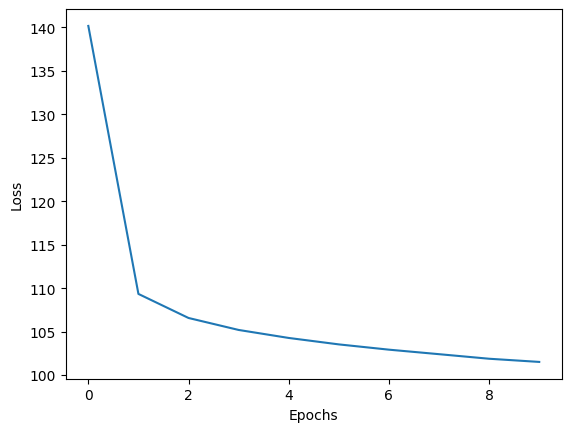

In [13]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### 학습 결과 Display


학습된 모델의 encoder, decoder를 통과한 Reconstruction 성능입니다.

Original images


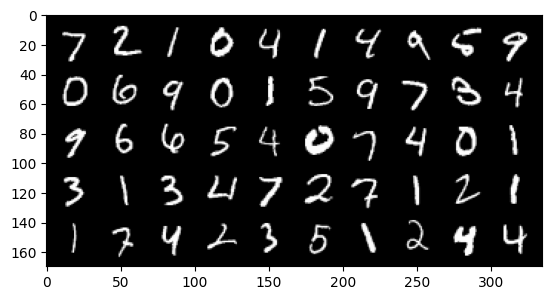

VAE reconstruction:


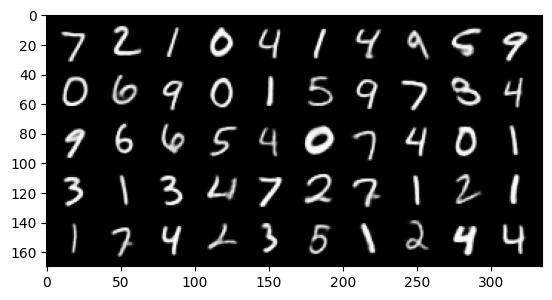

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(DEVICE)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

x_test, y_test = next(iter(test_loader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(x_test[:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(x_test, vae)

학습된 모델의 encoder로 뽑은 latent 간의 interpolation을 적용한 결과입니다.

tensor([[ 0.7162, -0.8907,  0.0446, -0.1182,  0.1054,  0.8025, -1.0650, -0.2985,
          0.8176,  0.3363, -1.0426,  0.7197, -0.7244, -0.4218,  0.2632,  2.9007,
          0.3634, -1.4595,  1.5870, -0.1277, -0.9226,  0.3294,  0.0409, -0.8165,
         -0.5294,  0.5840,  1.0588,  1.2916,  1.1092, -0.0900,  0.4387,  0.4137]],
       device='cuda:0')
tensor([[ 0.5592, -0.6704,  0.1197, -0.0909,  0.1520,  0.5174, -0.9074, -0.4032,
          0.6223,  0.4280, -1.0751,  0.5571, -0.5869, -0.4518,  0.2446,  2.5205,
          0.3306, -1.1817,  1.5134, -0.1026, -0.7302,  0.3127,  0.0303, -0.8819,
         -0.4121,  0.5622,  0.8647,  1.3196,  1.0682, -0.0930,  0.5436,  0.2470]],
       device='cuda:0')
tensor([[ 0.4022, -0.4501,  0.1948, -0.0636,  0.1985,  0.2322, -0.7498, -0.5079,
          0.4269,  0.5198, -1.1076,  0.3946, -0.4494, -0.4817,  0.2261,  2.1403,
          0.2978, -0.9040,  1.4398, -0.0775, -0.5379,  0.2960,  0.0197, -0.9473,
         -0.2948,  0.5405,  0.6706,  1.3475,  1.0273, -0.

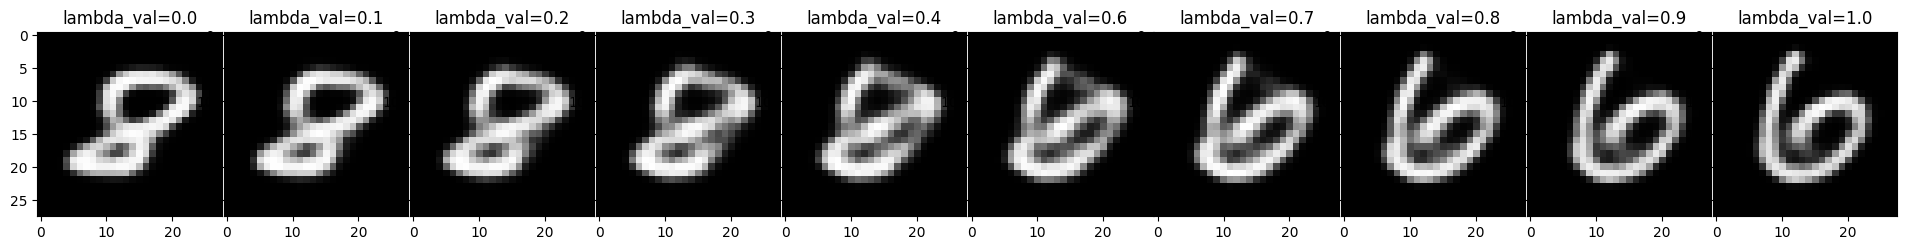

In [16]:
def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(DEVICE)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(DEVICE)
        latent_2, _ = model.encoder(img2)
        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2
        print(inter_latent)
        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for x_test, y_test in test_loader:
    for i in range(x_test.size(0)):
        digits[y_test[i]].append(x_test[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(1,10, figsize=(24, 6))
fig.subplots_adjust(hspace = .5, wspace=.01)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[6][0], digits[8][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

아래 내용은 학습된 모델의 Inference 결과를 확인하는 코드입니다.

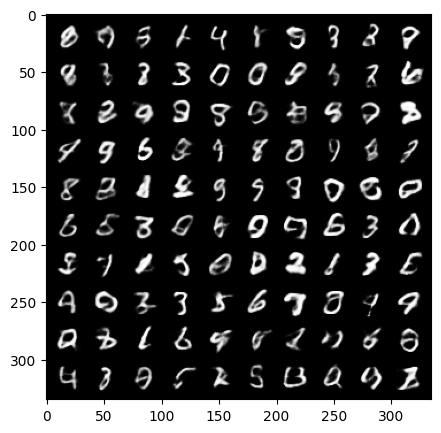

In [17]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=DEVICE)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

### Latent 분포 시각화

latent의 분포를 시각화해보도록 하겠습니다.

/home/devrok/.conda/envs/nlp_pt/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


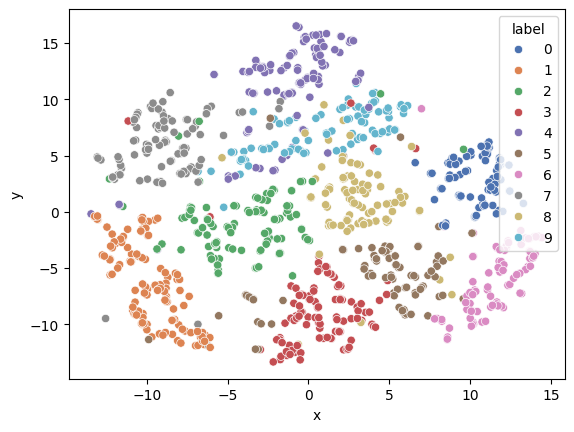

In [18]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

vae.eval()

n_samples = 1000
with torch.no_grad():
    z_mu_test, z_test_logvar = vae.encoder(x_test[:n_samples].to(DEVICE))
    z_test = vae.latent_sample(z_mu_test, z_test_logvar).cpu().numpy()

def plot_tsne(inputs, labels):
  n_samples = len(labels)
  tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
  tsne_features = tsne.fit_transform(inputs[:n_samples].reshape(n_samples, -1))
  df = pd.DataFrame({
      'x': tsne_features[:,0],
      'y': tsne_features[:,1],
      'label': labels[:n_samples]
  })

  sns.scatterplot(data=df, x='x', y='y', hue='label', palette="deep")

plot_tsne(z_test, y_test)